<a href="https://colab.research.google.com/github/Aditri-07/BlockHouse-Trial-Work/blob/main/Slippage_calculation_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Slippage Calculation

## VWAP Calculation
The Volume Weighted Average Price (VWAP) is calculated as follows:
$$
\text{VWAP} = \frac{\sum_{i=1}^{N} P_i \times V_i}{\sum_{i=1}^{N} V_i}
$$
where $ P_i$ is the price of the trade $i$ and $V_i$ is the volume of the trade $i$.

## Slippage Calculation
Slippage is calculated as:
$$
\text{Slippage} = \frac{\sum_{i=1}^{T} (P_i - \text{VWAP}) \times V_i}{\sum_{i=1}^{T} V_i}
$$
where $T$ is the total number of trades executed.

# PPO Training

## Clipped Surrogate Objective

In Proximal Policy Optimization (PPO), the clipped surrogate objective function is designed to stabilize policy updates by clipping the probability ratio. The objective is:

$$
L^{CLIP}(\theta) = \mathbb{E}_t \left[ \min \left( r_t(\theta) \hat{A}_t, \text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon) \hat{A}_t \right) \right]
$$

where:
- $r_t(\theta) = \frac{\pi_\theta(a_t | s_t)}{\pi_{\text{old}}(a_t | s_t)}$ is the probability ratio between the new and old policy.
- $\hat{A}_t $ is the advantage estimate.
- $\text{clip}(r_t(\theta), 1 - \epsilon, 1 + \epsilon)$ clips the ratio to prevent large updates.

## Value Function Loss

The value function loss is used to minimize the error between the predicted value function and the target value function. It is defined as:

$$
L^{VF}(\theta) = \mathbb{E}_t \left[ (V_\theta(s_t) - V_t^\text{target})^2 \right]
$$

where:
- $V_\theta(s_t)$ is the predicted value function for state $s_t$.
- $V_t^\text{target}$  is the target value, often computed using temporal difference methods or returns.

## Entropy Bonus

The entropy bonus encourages exploration by penalizing deterministic policies. It is computed as:

$$
S[\pi](s_t) = \mathbb{E}_t \left[ \log \pi(a_t | s_t) \right]
$$

where:
- $\pi(a_t | s_t)$ is the probability of taking action $a_t$ given state $s_t$.

## Total PPO Objective

The total PPO objective combines the clipped surrogate objective, value function loss, and entropy bonus into one loss function used for training. It is:

$$
L^{PPO}(\theta) = \mathbb{E}_t \left[ L^{CLIP}(\theta) - c_1 L^{VF}(\theta) + c_2 S[\pi](s_t) \right]
$$

where:
- $L^{CLIP}(\theta)$ is the clipped surrogate objective.
- $ L^{VF}(\theta)$ is the value function loss.
- $S[\pi](s_t)$ is the entropy bonus.
- $c_1$ and $c_2$ are coefficients that balance the importance of the value function loss and entropy bonus, respectively.


In [9]:
import yfinance as yf

# Fetch data
ticker = "AAPL"
data = yf.download(ticker, start="2023-01-01", end="2023-12-31")

# Example data processing
prices = data['Close'].values
volumes = data['Volume'].values


[*********************100%%**********************]  1 of 1 completed


In [27]:
import gym
import numpy as np
from gym import spaces

class TradingEnv(gym.Env):
    def __init__(self, prices, volumes):
        super(TradingEnv, self).__init__()
        self.prices = prices
        self.volumes = volumes
        self.n = len(prices)
        self.action_space = spaces.Discrete(2)  # Buy or Sell
        self.observation_space = spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)
        self.current_step = 0
        self.done = False
        self.history = []

    def calculate_vwap(self): #calculate VWAP function usig the formula mentioned above
        vwap = np.sum(self.prices * self.volumes) / np.sum(self.volumes)
        return vwap

    def calculate_slippage(self, action):
        vwap = self.calculate_vwap()
        executed_price = self.prices[self.current_step] if action == 1 else self.prices[self.current_step] - 0.5
        slippage = (executed_price - vwap) * self.volumes[self.current_step]
        return slippage #Slippage is the difference between the executed price and VWAP, weighted by volume

    def reset(self): #reset function - resets the env to the initial state and returns the initial observation
        self.current_step = 0
        self.done = False
        self.history = [] #clear history on reset
        return np.array([0.0])

    def step(self, action): #step function - executes the action, calculates slippage, and computes the reward (negative slippage) and then Updates the current step and checks if the episode is done. Returns the new observation, reward, done flag, and additional info
        slippage = self.calculate_slippage(action)
        reward = -slippage  # Minimize slippage
        self.history.append((self.current_step, self.prices[self.current_step], action, slippage)) #record action, reward in history
        self.current_step += 1
        self.done = self.current_step >= self.n
        return np.array([self.current_step / self.n]), reward, self.done, {}

# create an instance of trading environment given prices and volumes
env = TradingEnv(prices, volumes)


In [5]:
!pip install stable_baselines3[extra]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv #vectorized environments

# wrap the env - expectations: vectorized env
env = DummyVecEnv([lambda: TradingEnv(prices, volumes)])

# Define and train the PPO agent
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Save and load the model
model.save("ppo_trading")
model = PPO.load("ppo_trading")

# Test the trained model
test_env = TradingEnv(prices, volumes)
obs = test_env.reset()
for _ in range(len(prices)):
    action, _ = model.predict(obs)
    obs, reward, done, _ = test_env.step(action)
    print(f"Action: {action}, Reward: {reward}")
    if done:
        break #resets the environment and runs the model to predict actions and get rewards, then prints the action taken and the resulting reward for each step.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1063 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
--------------------------------------------
| time/                   |                |
|    fps                  | 726            |
|    iterations           | 2              |
|    time_elapsed         | 5              |
|    total_timesteps      | 4096           |
| train/                  |                |
|    approx_kl            | -2.0372681e-10 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -0.693         |
|    explained_variance   | 0              |
|    learning_rate        | 0.0003         |
|    loss                 | 7.47e+19       |
|    n_updates            | 10             |
|    policy_gradient_loss | 9.91e-10       |
|    value_loss           | 1.87e+20       |
--------

In [29]:
history = test_env.history
print(history)

[(0, 125.06999969482422, array(1), -5137066934.187208), (1, 126.36000061035156, array(0), -4012660606.0717893), (2, 125.0199966430664, array(1), -3713645983.456737), (3, 129.6199951171875, array(1), -3621514052.236759), (4, 130.14999389648438, array(1), -2883918526.090137), (5, 130.72999572753906, array(1), -2565982218.5614753), (6, 133.49000549316406, array(0), -2632394694.9563336), (7, 133.41000366210938, array(1), -2675207224.3734803), (8, 134.75999450683594, array(0), -2117488702.440003), (9, 135.94000244140625, array(1), -2224359417.5880322), (10, 135.2100067138672, array(1), -2485827503.2991505), (11, 135.27000427246094, array(1), -2075866013.96186), (12, 137.8699951171875, array(0), -2688983161.0317264), (13, 141.11000061035156, array(1), -2434707230.230754), (14, 142.52999877929688, array(0), -1917224066.5327015), (15, 141.86000061035156, array(1), -1910061528.3123953), (16, 143.9600067138672, array(1), -1456974239.5892065), (17, 145.92999267578125, array(0), -1796252415.753163

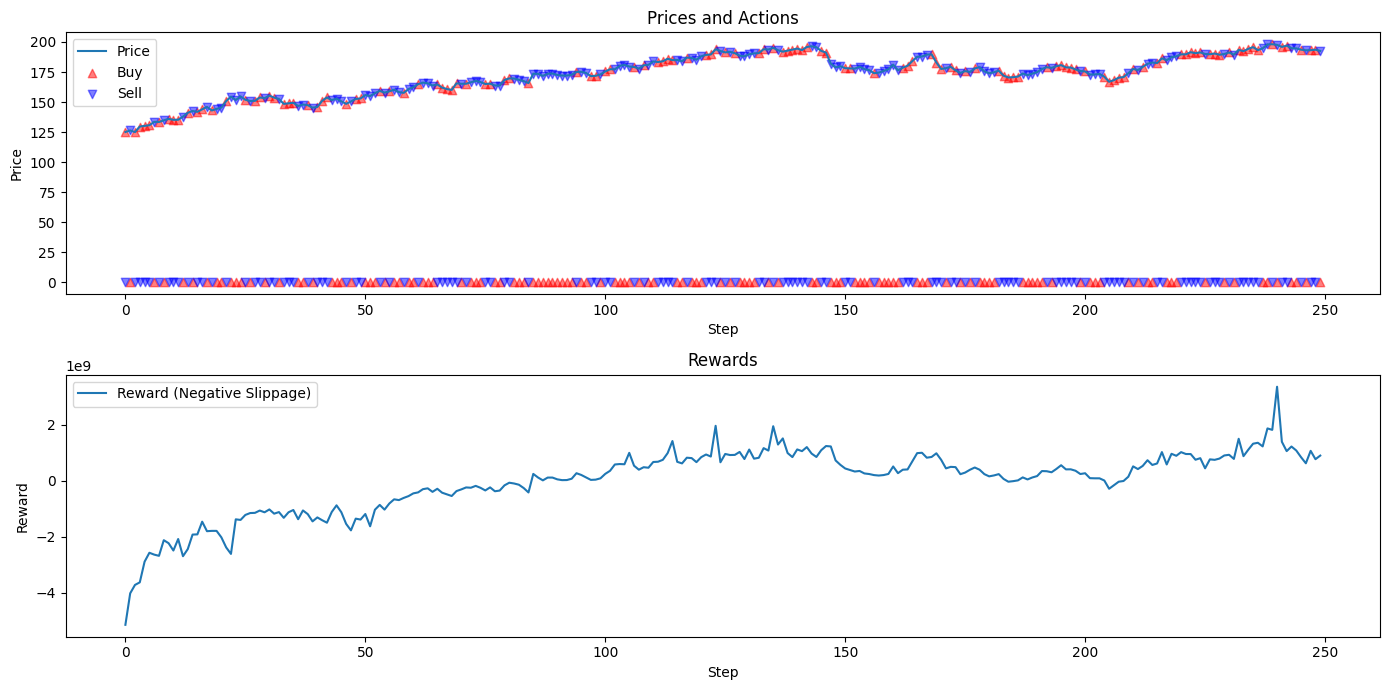

In [30]:
import matplotlib.pyplot as plt

# Extract history components
steps, prices, actions, rewards = zip(*history)

# Plot prices and actions
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(steps, prices, label='Price')
plt.scatter(steps, np.array(prices) * np.array(actions), color='red', label='Buy', marker='^', alpha=0.5)
plt.scatter(steps, np.array(prices) * (1 - np.array(actions)), color='blue', label='Sell', marker='v', alpha=0.5)
plt.title('Prices and Actions')
plt.xlabel('Step')
plt.ylabel('Price')
plt.legend()

# Plot rewards (negative slippage)
plt.subplot(2, 1, 2)
plt.plot(steps, rewards, label='Reward (Negative Slippage)')
plt.title('Rewards')
plt.xlabel('Step')
plt.ylabel('Reward')
plt.legend()

plt.tight_layout()
plt.show()


### Interpretation of the Graphs:

Prices and Actions:
- There's an overall upward trend with fluctuations throughout the period.
- The buy and sell actions appear frequent and often close to each other, indicating a high trading frequency.
- Ideally, buys should occur at relatively lower prices and sells at relatively higher prices.

Rewards:
- The graph shows an upward trend, indicating that the model's performance improves over time in terms of minimizing slippage.


